In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
from torch import nn
import torchvision
from torchinfo import summary
from torchvision import transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# handy functions written in a .py file and stored inside a directory named 'modular' for reuse
from modular import engine, data_setup, utils, helper_functions

C:\Users\User\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### GPU enabled

In [449]:
!nvidia-smi

Wed Feb 12 13:19:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   42C    P8             11W /   95W |     941MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Getting Data

Using Sorghum Disease Image Dataset

Source : https://data.mendeley.com/datasets/fgb3cmfrg2/1

getting images into train and validation to avoid overfitting

In [3]:
import os
import shutil
import random

# Define paths
source_dir = "Sorghum Disease Image Dataset/"  # Root directory containing label folders
output_dir = "train_test_dataset/"  # Destination directory for train/test split

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "validation")

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Iterate through each label folder
for label in os.listdir(source_dir):
    label_path = os.path.join(source_dir, label)
    
    if not os.path.isdir(label_path):
        continue  # Skip non-folder files
    
    # Get all image paths
    images = [f for f in os.listdir(label_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    if not images:  # Skip empty folders
        print(f"Skipping empty folder: {label_path}")
        continue

    random.shuffle(images)  # Shuffle images to ensure randomness
    
    # Define the split index (80% training, 20% validation)
    split_idx = int(0.8 * len(images))  

    # Split the dataset
    train_images = images[:split_idx]  # 80% train set
    val_images = images[split_idx:]   # 20% validation set
    
    # Create label directories in train and validation folders
    train_label_dir = os.path.join(train_dir, label)
    val_label_dir = os.path.join(val_dir, label)
    
    os.makedirs(train_label_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)
    
    # Move images to respective folders
    for img in train_images:
        src = os.path.join(label_path, img)
        dst = os.path.join(train_label_dir, img)
        shutil.move(src, dst)

    for img in val_images:
        src = os.path.join(label_path, img)
        dst = os.path.join(val_label_dir, img)
        shutil.move(src, dst)
    
    print(f"Processed label '{label}': {len(train_images)} train, {len(val_images)} test")

print("Dataset successfully split into train and validation sets.")

Skipping empty folder: Sorghum Disease Image Dataset/Anthracnose and Red Rot
Skipping empty folder: Sorghum Disease Image Dataset/Cereal Grain molds
Skipping empty folder: Sorghum Disease Image Dataset/Covered Kernel smut
Skipping empty folder: Sorghum Disease Image Dataset/Head Smut
Skipping empty folder: Sorghum Disease Image Dataset/loose smut
Skipping empty folder: Sorghum Disease Image Dataset/Rust
Dataset successfully split into train and validation sets.


In [4]:
# Checking data path
for dirpath, dirnames, filenames in os.walk("train_test_dataset/"):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'train_test_dataset/'.
There are 0 directories and 15 images in 'train_test_dataset/test'.
There are 6 directories and 0 images in 'train_test_dataset/train'.
There are 0 directories and 810 images in 'train_test_dataset/train\Anthracnose and Red Rot'.
There are 0 directories and 976 images in 'train_test_dataset/train\Cereal Grain molds'.
There are 0 directories and 223 images in 'train_test_dataset/train\Covered Kernel smut'.
There are 0 directories and 399 images in 'train_test_dataset/train\Head Smut'.
There are 0 directories and 1421 images in 'train_test_dataset/train\loose smut'.
There are 0 directories and 1903 images in 'train_test_dataset/train\Rust'.
There are 6 directories and 0 images in 'train_test_dataset/validation'.
There are 0 directories and 203 images in 'train_test_dataset/validation\Anthracnose and Red Rot'.
There are 0 directories and 244 images in 'train_test_dataset/validation\Cereal Grain molds'.
There are 0 directories 

In [5]:
# Setup directory path
train_dir = "train_test_dataset//train"
val_dir = "train_test_dataset//validation"
test_dir = "train_test_dataset//test"
train_dir, val_dir, test_dir

('train_test_dataset//train',
 'train_test_dataset//validation',
 'train_test_dataset//test')

# 1. Experimenting with `EfficientNet B0` model

### Data Transformation using Manual Transformer

In [495]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                std = [0.229, 0.224, 0.225]) # default weights of efficientnet B0 (pretrained model)

train_transform = transforms.Compose([transforms.Resize(size = (224, 224)),
                                     transforms.RandomHorizontalFlip(p=0.5),  # Augmentation only for training images
                                     transforms.RandomRotation(10),
                                     transforms.ToTensor(), #  #gets image into range(0-1)
                                     normalize]) # #make sure image have the same distribution as ImageNet pretrained model

test_transform = transforms.Compose([transforms.Resize(size = (224, 224)),
                                      transforms.ToTensor(),
                                      normalize])

In [498]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = the best available / performing weights
weights

# # Automatic transfroms can alsp be used
# # Get the transforms used to create pretrained weights
# auto_transforms = weights.transforms()
# auto_transforms

EfficientNet_B0_Weights.IMAGENET1K_V1

In [499]:
# DataLoaders using manual transforms
from modular import data_setup # function file at root directory
train_dataloader, val_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                              test_dir = val_dir,
                                                                              train_transform = train_transform,
                                                                              test_transform = test_transform,
                                                                              batch_size = 32)

train_dataloader, val_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1fa7b6d9990>,
 ['Anthracnose and Red Rot',
  'Cereal Grain molds',
  'Covered Kernel smut',
  'Head Smut',
  'Rust',
  'loose smut'])

# Model

## Getting a pretrained model

source = https://pytorch.org/vision/stable/models.html

In [541]:
# Setting up a instance of pretrained model
eff_net_model_1 = torchvision.models.efficientnet_b0(weights = weights)
eff_net_model_1.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [544]:
eff_net_model_1.avgpool

AdaptiveAvgPool2d(output_size=1)

In [545]:
eff_net_model_1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [546]:
from torchinfo import summary

summary(model = eff_net_model_1,
       input_size = (1, 3, 224, 224),
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [547]:
# Check the classifier head
eff_net_model_1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [548]:
# Update the classifier head of the model to suit this problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

eff_net_model_1.classifier = nn.Sequential(
                                nn.Dropout(p = 0.2, inplace = True),
                                nn.Linear(in_features = 1280,
                                         out_features = len(class_names))).to(device)

eff_net_model_1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=6, bias=True)
)

In [549]:
# After freezing the base layers (partial trainability) only the output layers are trainable
# After updating classifier

summary(model = eff_net_model_1,
       input_size = (1, 3, 224, 224),
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 6]               --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## Fitting data into the model

In [550]:
# Define loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eff_net_model_1.parameters(),
                            lr = 0.001)

In [551]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model = eff_net_model_1,
                      train_dataloader = train_dataloader,
                      test_dataloader = val_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      epochs = 10,
                      device = device)

end_time = timer()

print(f"[INFO] Total time to train: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3769 | train_acc: 0.8656 | test_loss: 0.1200 | test_acc: 0.9604
Epoch: 2 | train_loss: 0.1570 | train_acc: 0.9481 | test_loss: 0.0919 | test_acc: 0.9583
Epoch: 3 | train_loss: 0.0809 | train_acc: 0.9701 | test_loss: 0.0849 | test_acc: 0.9715
Epoch: 4 | train_loss: 0.0857 | train_acc: 0.9734 | test_loss: 0.1582 | test_acc: 0.9611
Epoch: 5 | train_loss: 0.1114 | train_acc: 0.9649 | test_loss: 0.0619 | test_acc: 0.9789
Epoch: 6 | train_loss: 0.0871 | train_acc: 0.9729 | test_loss: 0.0554 | test_acc: 0.9895
Epoch: 7 | train_loss: 0.0917 | train_acc: 0.9717 | test_loss: 0.0374 | test_acc: 0.9910
Epoch: 8 | train_loss: 0.0340 | train_acc: 0.9899 | test_loss: 0.0154 | test_acc: 0.9951
Epoch: 9 | train_loss: 0.0540 | train_acc: 0.9835 | test_loss: 0.0495 | test_acc: 0.9889
Epoch: 10 | train_loss: 0.0727 | train_acc: 0.9793 | test_loss: 0.0696 | test_acc: 0.9789
[INFO] Total time to train: 1093.0630883001722


In [552]:
model_1_results

{'train_loss': [0.37687231260869236,
  0.15698301454799043,
  0.08088320815651161,
  0.08572022749382692,
  0.1114387501962483,
  0.08709893283602367,
  0.09171680923577191,
  0.0339515990807235,
  0.05401448574007696,
  0.0727111745360566],
 'train_acc': [0.865625,
  0.9480902777777778,
  0.9701388888888889,
  0.9734375,
  0.9649305555555555,
  0.9729166666666667,
  0.9717013888888889,
  0.9899305555555555,
  0.9835069444444444,
  0.9793402777777778],
 'test_loss': [0.1199740693574616,
  0.09194879766518069,
  0.08491878456184673,
  0.1581657890485278,
  0.061879051961759995,
  0.055433469960310726,
  0.037444235952153175,
  0.015372939028430387,
  0.049490236615030075,
  0.06963717529418116],
 'test_acc': [0.9604166666666667,
  0.9583333333333334,
  0.9715277777777778,
  0.9611111111111111,
  0.9789094650205761,
  0.989454732510288,
  0.9909722222222223,
  0.9951388888888889,
  0.9888888888888889,
  0.9789094650205761]}

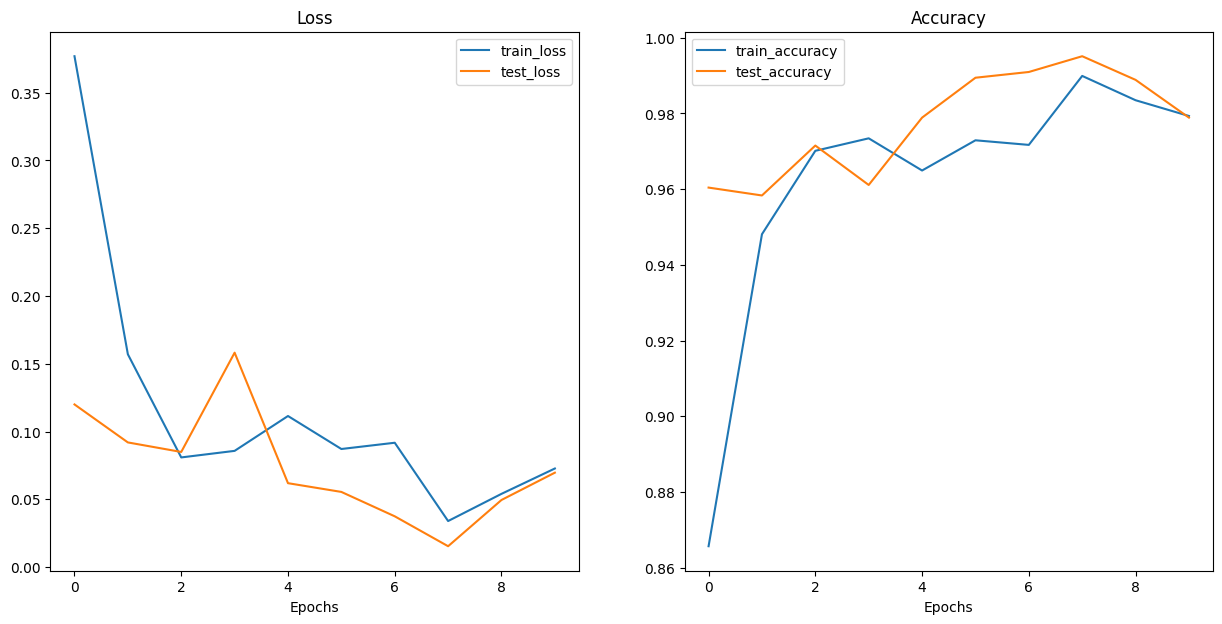

In [574]:
# Plot loss curves of above model
helper_functions.plot_loss_curves(model_1_results)

In [575]:
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt


# 1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str],
                       image_size: Tuple[int, int] = (224, 224),
                       transform: torchvision.transforms = None,
                       device: torch.device = device):
    
    # 2. Open the image with PIL
    img = Image.open(image_path)
    
    # 3. Create a transform if doesn't exist
    image_transform = test_transform
        
    # Predict on image---------------------------
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim = 0) #[B, C, H, W]
        
        # 7. Make a prediction on the transformed image by passing it to the model (also ensure it is on the target device)
        target_image_pred = model(transformed_image.to(device))
        
        # 8. Convert the model's output logits to pred probs
        target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
        
        # 9. Convert the model's pred probs to pred labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)
        
        # 10. Plot image with predicted label and probability
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | {target_image_pred_probs.max():.3f}")
        plt.axis(False);
    

Sampling 15 images out of 15


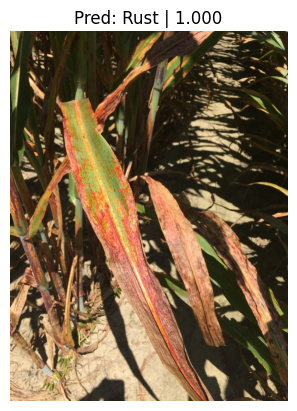

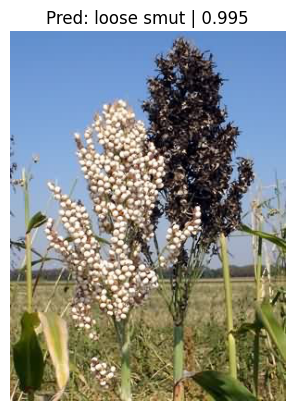

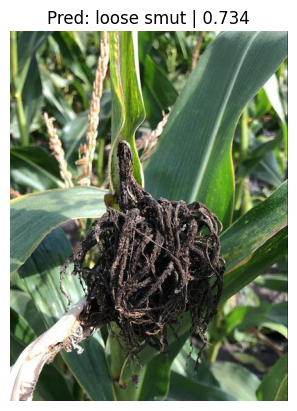

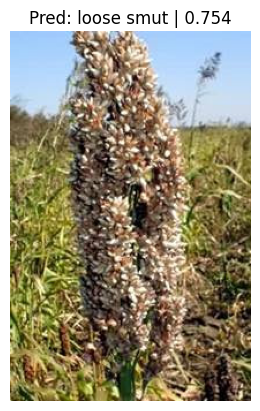

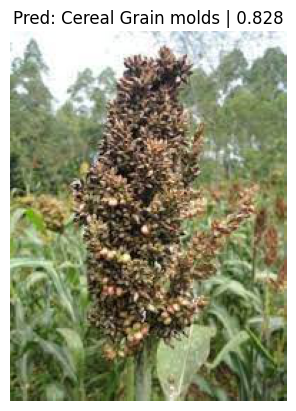

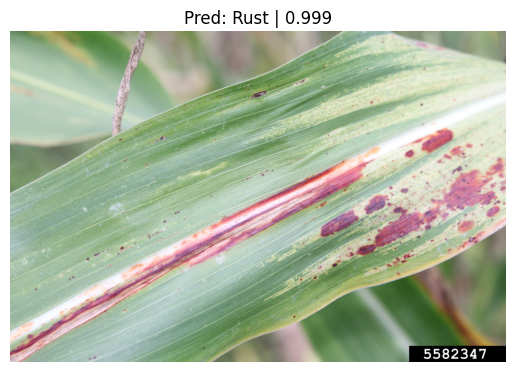

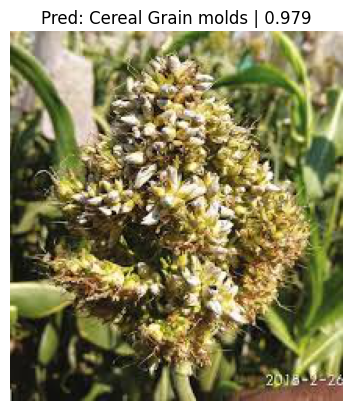

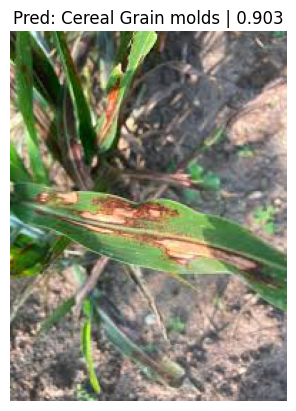

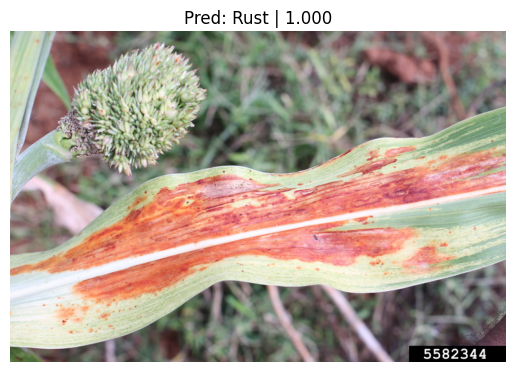

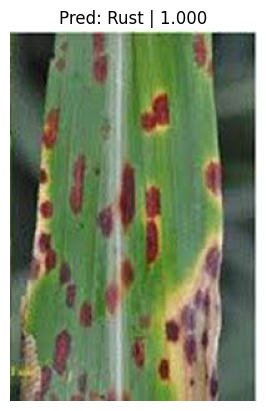

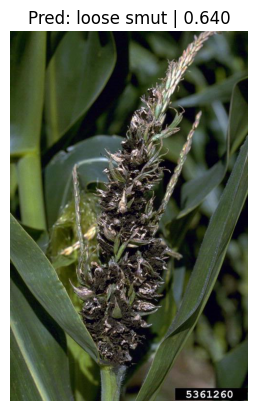

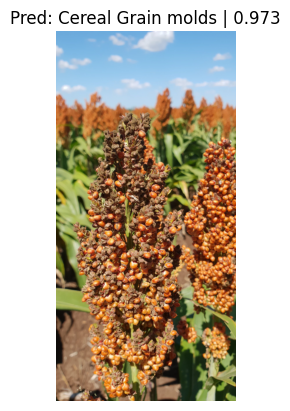

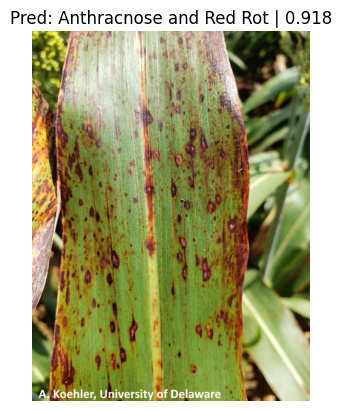

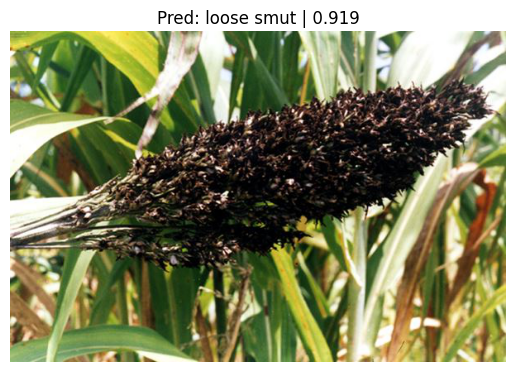

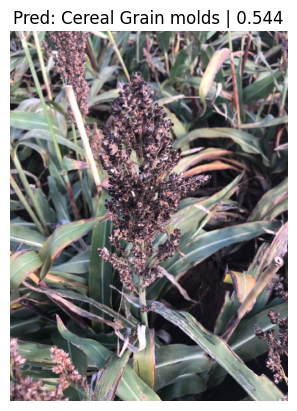

In [576]:
# Get a random list of image paths from the test set
import random
from pathlib import Path

num_images_to_plot = 15
test_image_path_list = list(Path(test_dir).glob("*.jpg"))

# Ensure k does not exceed available images
num_images_available = len(test_image_path_list)
num_images_to_sample = min(num_images_to_plot, num_images_available)

test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_sample)

print(f"Sampling {num_images_to_sample} images out of {num_images_available}")

# Predictions and plot
for image_path in test_image_path_sample:
    pred_and_plot_image(model=eff_net_model_1,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224),
                        device=device)


### Saving the efficient net model for future use

In [577]:
utils.save_full_model(model = eff_net_model_1,
                           target_dir = "models",
                           model_name = "full_model_effnet_sorghum.pth"
                           )

[INFO] Saving model to: models\full_model_effnet_sorghum.pth


-------------------------------------------------

# 2. Experimenting with self coded Vision-Transformer model

In [6]:
# Create image size
IMG_SIZE = 224 #from the table 3 of ViT paper (16 x 16 words)

# Create transforms pipeline
manual_transforms = transforms.Compose([
                                       transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor()
                                       ])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Create a batch size of 32 (the paper uses 4096 which may be too big for smaller hardware)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader_manual_vit, test_dataloader_manual_vit, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                              test_dir = val_dir,
                                                                              train_transform = manual_transforms,
                                                                              test_transform = manual_transforms,
                                                                              batch_size = BATCH_SIZE)
len(train_dataloader_manual_vit), len(test_dataloader_manual_vit), class_names

(180,
 45,
 ['Anthracnose and Red Rot',
  'Cereal Grain molds',
  'Covered Kernel smut',
  'Head Smut',
  'Rust',
  'loose smut'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader_manual_vit))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

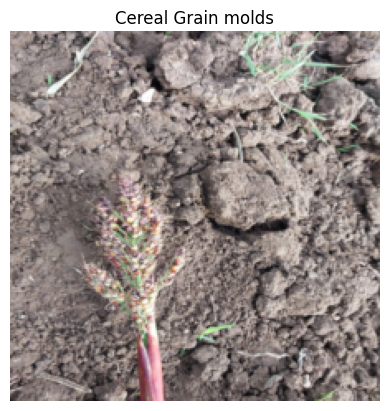

In [9]:
# Plot the image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # C, H, W
plt.title(class_names[label])
plt.axis(False);

In [10]:
# Create exmale values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [11]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")
      

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


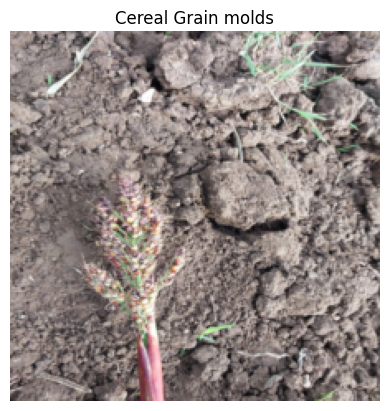

In [12]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

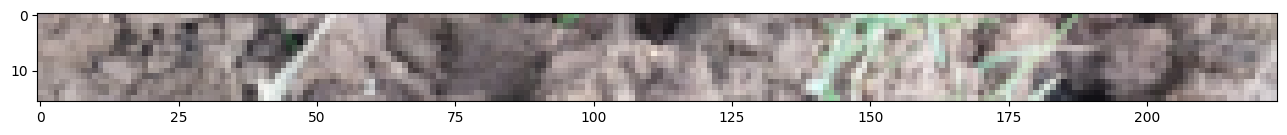

In [13]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, : , : ])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


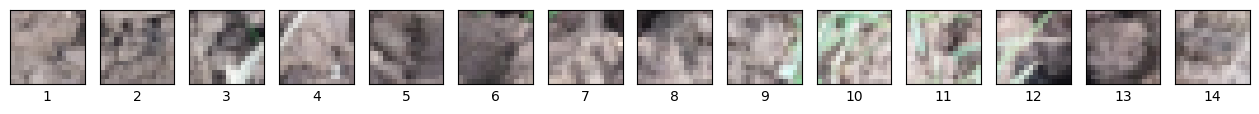

In [14]:
# Setup code to plot top row
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows = 1,
                       ncols = img_size // patch_size, # one column for each patch
                       sharex = True,
                       sharey = True,
                       figsize = (patch_size, patch_size)
                       )

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :]);
    axs[i].set_xlabel(i+1) # Set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0    
Number of patches per column: 14.0    
Total patches: 196.0    
Patch size: 16 pixels x 16 pixels


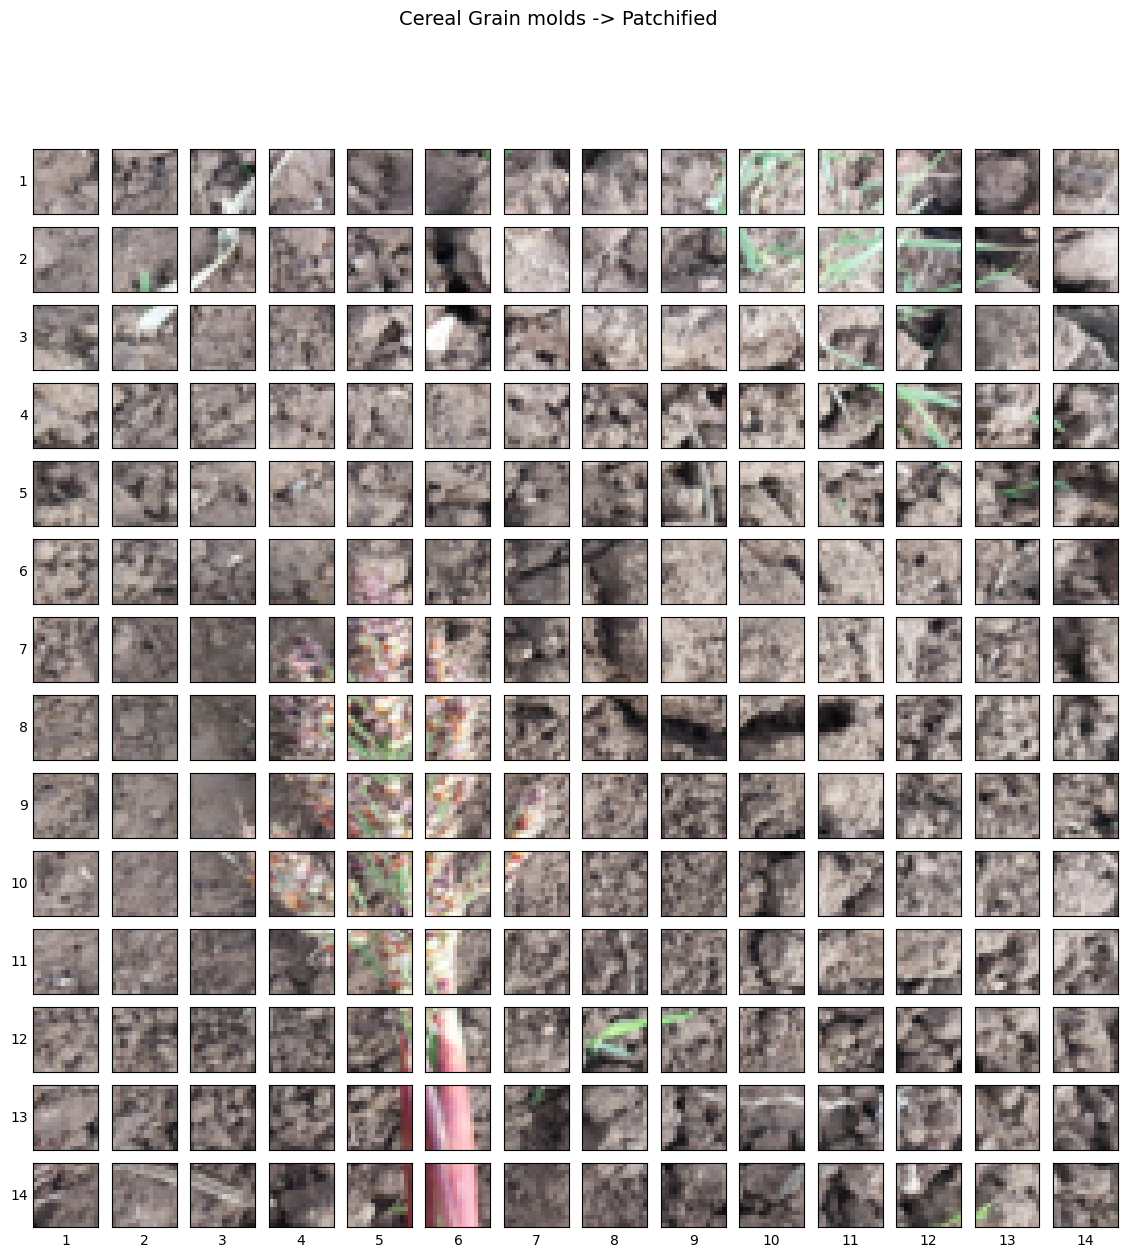

In [15]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
    \nNumber of patches per column: {num_patches}\
    \nTotal patches: {num_patches*num_patches}\
    \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows = img_size // patch_size,
                       ncols = img_size // patch_size,
                       figsize = (num_patches, num_patches),
                       sharex = True,
                       sharey = True
                       )

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        # Plot the permuted image on the different axes
        axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size, # iterate through height
                                       patch_width:patch_width + patch_size, # iterate through width
                                        : ])
        # Setup label information for each subplot (patch)
        axs[i, j].set_ylabel(i+1,
                            rotation = "horizontal",
                            horizontalalignment = "right",
                            verticalalignment = "center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
# Setup a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)
plt.show()

### Creating image patches and turning them into patch embeddings

In [16]:
# Creating conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the VIT paper
conv2d = nn.Conv2d(in_channels = 3, # for colour images
                  out_channels = 768, # D size from Table 1 for ViT base
                  kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

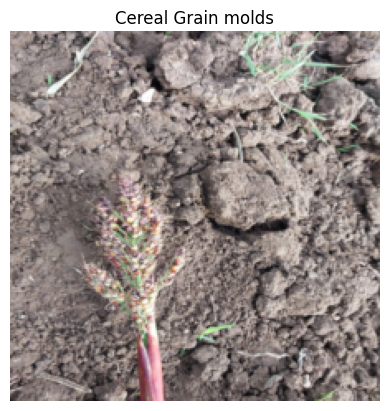

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


##### After passing a single image to `conv2d` layer, it's shape is:
torch.size([1, 768, 14, 14]) ---------- (batch_size, embedding_dim, feature_map_height, feature_map_width)

In [19]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [292, 642, 519, 750, 471]


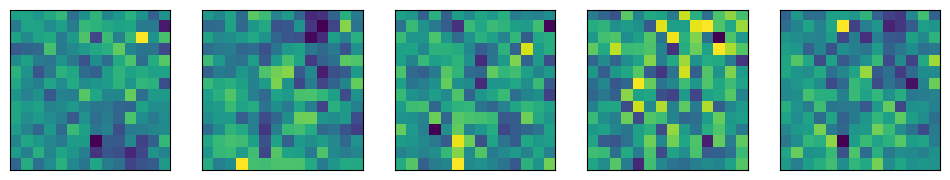

In [20]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[ : , idx, : , : ] # index on the output tensor of the conv2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
    axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

In [21]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[ : , 0, : , :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.6898, -0.6362, -0.4192, -0.7611, -0.4406, -0.3493, -0.5958,
           -0.4677, -0.6809, -0.7452, -0.7685, -0.6199, -0.4074, -0.5900],
          [-0.4761, -0.5744, -0.8015, -0.5769, -0.4328, -0.4832, -0.8389,
           -0.7154, -0.4789, -0.6967, -0.8066, -0.4265, -0.3478, -0.6004],
          [-0.5837, -0.6954, -0.6773, -0.6137, -0.5405, -0.4757, -0.5949,
           -0.5979, -0.6968, -0.7550, -0.6967, -0.4547, -0.4577, -0.5070],
          [-0.7368, -0.5241, -0.5335, -0.6322, -0.5486, -0.7839, -0.6450,
           -0.5332, -0.5488, -0.4719, -0.5383, -0.6066, -0.7804, -0.5352],
          [-0.4340, -0.5454, -0.4610, -0.7196, -0.6100, -0.4672, -0.3917,
           -0.4777, -0.4617, -0.4548, -0.6465, -0.4257, -0.3454, -0.3347],
          [-0.6086, -0.5810, -0.4725, -0.5710, -0.6387, -0.4620, -0.3907,
           -0.4340, -0.6773, -0.6313, -0.6977, -0.5914, -0.6519, -0.3756],
          [-0.6114, -0.4390, -0.3755, -0.4792, -0.7143, -0.4629, -0.3470,
           -0.4131, -0.6998, -0.

##### Flattening the patch embedding with 'torch.nn.Flatten' 

* to satisfy the input criteria of ViT Encoder

In [22]:
print(f"{image_out_of_conv.shape} -> (batch size, embedding dim, feature map height, feature map width)")

torch.Size([1, 768, 14, 14]) -> (batch size, embedding dim, feature map height, feature map width)


Want: (batch size, number of patches, embedding dim)

In [23]:
flatten_layer = nn.Flatten(start_dim = 2,  # [0:1, 1:768, 2:14, 3:14]
                          end_dim = 3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

#### Putting everything together

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


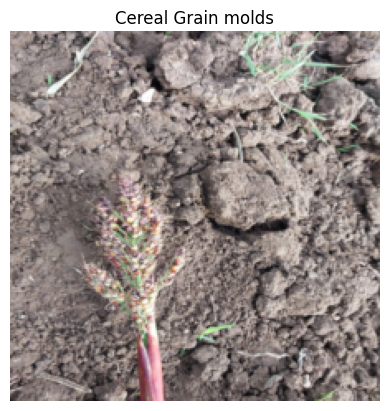

In [24]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [25]:
# Rearrange output of flattened layer
image_out_of_conv_flattened.permute(0, 2, 1).shape # Batch_size, number_of_patches, embedding_dimensions

torch.Size([1, 196, 768])

(-0.5, 195.5, 0.5, -0.5)

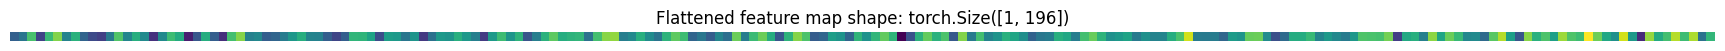

In [26]:
# Get a single flattened feature map
# getting only one embedding dimension [0th index]
single_flattened_feature_map = image_out_of_conv_flattened.permute(0, 2, 1)[ : , : ,0]
single_flattened_feature_map

# Plot the flattened map visually
plt.figure(figsize = (22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### Turning the ViT patch embedding layer into a PyTorch module

1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn as image into embedding patches using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [27]:
# 1.
class PatchEmbedding(nn.Module):
    
    # 2.
    def __init__(self, 
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768): # from table 1 for ViT-Base
        super().__init__()
        
        # 3.
        self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels = embedding_dim,
                                 kernel_size = patch_size,
                                 stride = patch_size,
                                 padding = 0)
        
        # 4.
        self.flatten = nn.Flatten(start_dim = 2,
                                        end_dim = 3)
    # 5.    
    def forward(self, x):
        # Create assertion to check that inputs are correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform fordward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # 6. dimensions to be -> [batch_size, no_of_patches, embedding_dimension]
        return x_flattened.permute(0, 2, 1)

In [28]:
# Setting seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Creating an instance of patch embedding
patchify = PatchEmbedding(in_channels = 3,
                         patch_size = 16,
                         embedding_dim = 768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


### Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding

In [29]:
patch_embedded_image

tensor([[[-0.6022,  0.0967, -0.1223,  ...,  0.4342, -0.2058,  0.2430],
         [-0.4833,  0.1256, -0.1335,  ...,  0.3364, -0.2565,  0.3541],
         [-0.4360,  0.2505, -0.3440,  ...,  0.4553, -0.2287,  0.2664],
         ...,
         [-0.5513,  0.0973, -0.1870,  ...,  0.2934, -0.2996,  0.1495],
         [-0.5681,  0.3019, -0.1544,  ...,  0.5518, -0.2254,  0.1000],
         [-0.6275, -0.0408, -0.0766,  ...,  0.3560, -0.2887,  0.1524]]],
       grad_fn=<PermuteBackward0>)

In [30]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [31]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad = True)

class_token.shape

torch.Size([1, 1, 768])

In [32]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [33]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                     dim = 1) # number_of_patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_batches)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6022,  0.0967, -0.1223,  ...,  0.4342, -0.2058,  0.2430],
         [-0.4833,  0.1256, -0.1335,  ...,  0.3364, -0.2565,  0.3541],
         ...,
         [-0.5513,  0.0973, -0.1870,  ...,  0.2934, -0.2996,  0.1495],
         [-0.5681,  0.3019, -0.1544,  ...,  0.5518, -0.2254,  0.1000],
         [-0.6275, -0.0408, -0.0766,  ...,  0.3560, -0.2887,  0.1524]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_batches)


### Creating the position embedding

Want to: create a series of 1D learnable position embeddings to add them to the sequence 

In [34]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6022,  0.0967, -0.1223,  ...,  0.4342, -0.2058,  0.2430],
          [-0.4833,  0.1256, -0.1335,  ...,  0.3364, -0.2565,  0.3541],
          ...,
          [-0.5513,  0.0973, -0.1870,  ...,  0.2934, -0.2996,  0.1495],
          [-0.5681,  0.3019, -0.1544,  ...,  0.5518, -0.2254,  0.1000],
          [-0.6275, -0.0408, -0.0766,  ...,  0.3560, -0.2887,  0.1524]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# Calculate N (number of patches)
number_of_patches = int((height*width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches + 1,
                                            embedding_dimension,
                                            requires_grad = True))
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [36]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3978, 1.0967, 0.8777,  ..., 1.4342, 0.7942, 1.2430],
         [0.5167, 1.1256, 0.8665,  ..., 1.3364, 0.7435, 1.3541],
         ...,
         [0.4487, 1.0973, 0.8130,  ..., 1.2934, 0.7004, 1.1495],
         [0.4319, 1.3019, 0.8456,  ..., 1.5518, 0.7746, 1.1000],
         [0.3725, 0.9592, 0.9234,  ..., 1.3560, 0.7113, 1.1524]]],
       grad_fn=<AddBackward0>)

In [37]:
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

### Putting Equation 1 together: from image to embedding

In [38]:
# Set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the patch size
patch_size = 16

# Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                      embedding_dim = 768,
                                      patch_size = patch_size)

# Pass input image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad = True) # making sure it's learnable
print(f"CLass token embedding shape: {class_token.shape}")

# Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create a position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, 
                                             number_of_patches + 1,
                                             embedding_dimension),
                                             requires_grad = True)

# Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
CLass token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### Equation 2: Multihead Self-Attention (MSA block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?
    * In this case, we have a series of embedded image patches, which patch significantly relates to another patch.
    * We want our neural network (ViT) to learn this relationship/ representation.

* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
    * Normalization = make everything have the same mean and standard deviation.
    * In PyTorch, LayerNorm normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.



In [39]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                embedding_dim: int = 768, # Hidden size D (embedding dimension) from table 1
                num_heads: int = 12, # Heads from Table 1 for ViT base
                attn_dropout: int = 0):
        super().__init__()
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        # Create multihead attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                   num_heads = num_heads,
                                                   dropout = attn_dropout,
                                                   batch_first = True)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x,
                                            key = x,
                                            value = x,
                                            need_weights = False)
        return attn_output

In [40]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim = 768,
                                                            num_heads = 12,
                                                            attn_dropout = 0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [41]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3978, 1.0967, 0.8777,  ..., 1.4342, 0.7942, 1.2430],
         [0.5167, 1.1256, 0.8665,  ..., 1.3364, 0.7435, 1.3541],
         ...,
         [0.4487, 1.0973, 0.8130,  ..., 1.2934, 0.7004, 1.1495],
         [0.4319, 1.3019, 0.8456,  ..., 1.5518, 0.7746, 1.1000],
         [0.3725, 0.9592, 0.9234,  ..., 1.3560, 0.7113, 1.1524]]],
       grad_fn=<AddBackward0>)

In [42]:
patched_image_through_msa_block

tensor([[[-0.2562, -0.2112,  0.0769,  ..., -0.4698,  0.9092, -0.5120],
         [-0.2594, -0.2098,  0.0794,  ..., -0.4660,  0.9086, -0.5152],
         [-0.2588, -0.2079,  0.0797,  ..., -0.4656,  0.9095, -0.5142],
         ...,
         [-0.2580, -0.2079,  0.0774,  ..., -0.4651,  0.9061, -0.5142],
         [-0.2579, -0.2093,  0.0787,  ..., -0.4650,  0.9075, -0.5146],
         [-0.2603, -0.2102,  0.0790,  ..., -0.4657,  0.9088, -0.5160]]],
       grad_fn=<TransposeBackward0>)

### Equation 3: Multilayer Perceptron Block

**MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
   * MLP = a quite term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
   * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFLow, they might be called `tf.keras.layers.Dense()`
   * MLP number of hidden units = MLP Size in Table 1
   
   * Value for Dropout available in table 3
   
$MLP$

x = linear -> non-linear -> dropout -> linear -> dropout

In [43]:
class MLPBlock(nn.Module):
    def __init__(self,
                embedding_dim: int = 768,
                mlp_size: int = 3072,
                dropout: int = 0.1):
        super().__init__()
        
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim,
                     out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlp_size,
                     out_features = embedding_dim),
            nn.Dropout(p = dropout)
                    )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x))

In [44]:
# Create an instance of MLP block
mlp_block = MLPBlock(embedding_dim = 768,
                    mlp_size = 3072,
                    dropout = 0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")


Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [45]:
patched_image_through_mlp_block

tensor([[[-0.0544,  0.0018,  0.1154,  ...,  0.0000, -0.1643,  0.1562],
         [-0.1106, -0.1068,  0.2155,  ..., -0.0647, -0.1332,  0.2078],
         [-0.0318, -0.0473,  0.2304,  ..., -0.0000, -0.2006,  0.1840],
         ...,
         [-0.2127,  0.0060,  0.2252,  ...,  0.1611, -0.1998,  0.2642],
         [-0.1512,  0.0526,  0.0000,  ...,  0.0897, -0.1844,  0.0735],
         [-0.0717, -0.0245,  0.1656,  ..., -0.0631, -0.1815,  0.1678]]],
       grad_fn=<MulBackward0>)

### Creating the Transformer Encoder

The Transformer Encoder is the combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learned representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

$Transformer Encoder$

x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ....


In [46]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                embedding_dim: int = 768, # Hidden size D from table 1, 768 for ViT-Base
                num_heads: int = 12, # from table 1
                mlp_size:int = 3072, # from table 1
                mlp_dropout:int = 0.1,# from table 3
                attn_dropout: int = 0 
                ):
        super().__init__()
        
        # Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                    num_heads = num_heads,
                                                    attn_dropout = attn_dropout)
        
        # Create MLP block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                                 mlp_size = mlp_size,
                                 dropout = mlp_dropout)
    
    def forward(self, x):
        x = self.msa_block(x) + x # residual/skip connection
        x = self.mlp_block(x) + x # residual/skip connection for equation 3
        return x

In [47]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model = transformer_encoder_block,
       input_size = (1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Create Transformer Encoder layer with in-built PyTorch layers

In [48]:
# Create the same sa above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                            nhead = 12,
                                                            dim_feedforward = 3072,
                                                            dropout = 0.1,
                                                            activation = "gelu",
                                                            batch_first = True,
                                                            norm_first = True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [49]:
# Get a summary using torchinfo.summary
summary(model = torch_transformer_encoder_layer,
       input_size = (1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# Putting it all together to create ViT

In [50]:
# Create a ViT class
class ViT(nn.Module):
    def __init__(self,
                img_size:int = 224, # Table 3 from the ViT paper
                in_channels:int = 3,
                patch_size:int = 16,
                num_transformer_layer:int = 12, # Table 1 for "Layers" for ViT-Base
                embedding_dim:int = 768, # hidden size D from Table 1 for ViT-Base
                mlp_size:int = 3072, # Table 1
                num_heads:int = 12, # Table 1
                attn_dropout:int = 0,
                mlp_dropout:float = 0.1,
                embedding_dropout:float = 0.1, # dropout for patch and position embeddings
                num_classes:int = 1000 # number of classes in our classification problem
                ):
        super().__init__()
        
        # Make an assertion that the image size if compatible with the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"
        
        # Calculate the number of patches (height * weight / patch**2)
        self.num_patches = (img_size * img_size) // patch_size**2
        
        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data = torch.rand(1, 1, embedding_dim),
                                           requires_grad = True)
        
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches +1, embedding_dim))
        
        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)
        
        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                             patch_size = patch_size,
                                             embedding_dim = embedding_dim)
        
        # Create the Transformer Encoder block
        self.Transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim = embedding_dim,
                                                                          num_heads = num_heads,
                                                                          mlp_size = mlp_size,
                                                                          mlp_dropout = mlp_dropout) for _ in range(num_transformer_layer)])
        
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(in_features = embedding_dim,
                     out_features = num_classes)
        )
    
    def forward(self, x):
        # Get the batch size
        batch_size = x.shape[0]
        
        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions
        
        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)
        
        # Concat class token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim = 1) # (batch_size, number_of_patches, embedding_dim)
        
        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x
        
        # Apply dropout to patch embedding ("directly after adding positional- to patch embedding")
        x = self.embedding_dropout(x)
        
        # Pass position and patch embedding to Transformer encoder (equation 2 & 3)
        x = self.Transformer_encoder(x)
        
        # Put the 0th index logit through the classifer (equation 4)
        x = self.classifier(x[:, 0]) # every batch 0th index
        
        return x

In [51]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (Transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [52]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (6 classes)
vit = ViT(num_classes = 1000)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-9.8183e-01, -1.2667e-01,  3.8942e-01, -2.4631e-01, -1.8254e-01,
          1.6708e-02, -4.0002e-01,  5.2375e-01,  5.3651e-01, -1.7576e-01,
          5.1386e-01,  2.0879e-01,  5.7766e-01,  4.1061e-01, -9.3039e-01,
         -1.6391e+00, -5.3440e-01, -1.1468e-01, -5.5327e-02, -1.1969e-01,
          9.6008e-02,  6.6538e-01,  3.4555e-02, -6.4681e-01, -3.1301e-02,
         -2.3166e-01,  8.1592e-01,  1.7400e-01, -1.9840e-01, -7.1783e-01,
         -3.2422e-01, -3.8689e-01,  2.0277e-01,  1.6087e-02,  3.7664e-01,
          1.0207e-01,  2.9553e-01, -6.4713e-01,  3.8639e-01,  7.5703e-01,
         -1.0262e+00, -9.8380e-01, -8.4783e-02,  1.7232e-01, -7.6095e-01,
         -2.3631e-02, -2.0222e-02, -3.0594e-01,  9.9899e-01,  3.3840e-01,
         -6.1593e-01,  4.3400e-01,  7.0257e-01, -4.9010e-01,  2.1753e-01,
         -7.5082e-01, -1.4963e-01, -1.0057e-01, -1.2809e+00,  2.7043e-01,
          1.8240e-01, -6.1540e-01, -3.6861e-01, -8.4763e-01,  2.9877e-01,
         -1.4972e-01, -1.6870e-01,  5.

In [53]:
# Get a summary using torchinfo.summary
summary(model = vit,
       input_size = (1, 3, 224, 224), # (batch_size, number_of_patches, embedding_dimension)
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (Transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## Setting up training code for ViT model

Weight decay - is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss funtion.

Regularization technique = prevents overfitting.

In [54]:
# Creating an optimizer (Adam is used in the paper with B1 value of 0.9, B2 of 0.999 (defaults))
optimizer = torch.optim.Adam(vit.parameters(),
                            lr = 1e-3, # 0.001
                            betas = (0.9, 0.999),
                            weight_decay = 0.1)

In [55]:
# Creating a loss function (paper doesnot mention this)
loss_fn = torch.nn.CrossEntropyLoss()

### Training ViT Model

In [56]:
manual_vit_results = engine.train(model = vit,
                       train_dataloader = train_dataloader_manual_vit,
                       test_dataloader = test_dataloader_manual_vit,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8163 | train_acc: 0.2858 | test_loss: 1.7061 | test_acc: 0.1694
Epoch: 2 | train_loss: 1.6735 | train_acc: 0.3057 | test_loss: 1.6539 | test_acc: 0.3306
Epoch: 3 | train_loss: 1.6622 | train_acc: 0.3233 | test_loss: 1.6870 | test_acc: 0.3306
Epoch: 4 | train_loss: 1.6716 | train_acc: 0.3222 | test_loss: 1.6620 | test_acc: 0.2507
Epoch: 5 | train_loss: 1.6904 | train_acc: 0.3234 | test_loss: 1.6765 | test_acc: 0.3306


In [57]:
manual_vit_results

{'train_loss': [1.8162727892398833,
  1.6735063115755717,
  1.6622308068805272,
  1.6715504030386608,
  1.6903612269295587],
 'train_acc': [0.2857638888888889,
  0.30572916666666666,
  0.3232638888888889,
  0.32222222222222224,
  0.3234375],
 'test_loss': [1.70609675778283,
  1.65390694671207,
  1.6869703080919054,
  1.6620471662945218,
  1.676468136575487],
 'test_acc': [0.16944444444444445,
  0.33055555555555555,
  0.33055555555555555,
  0.25069444444444444,
  0.33055555555555555]}

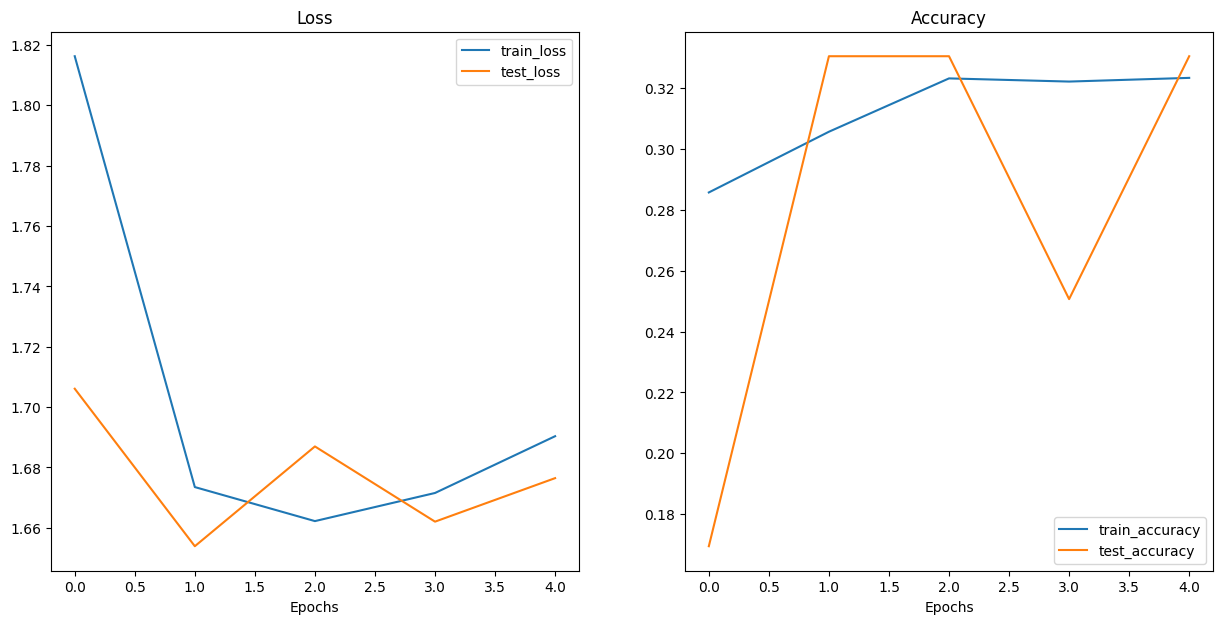

In [63]:
helper_functions.plot_loss_curves(manual_vit_results)

### Saving manual ViT model for future use

In [64]:
utils.save_full_model(model = vit,
                           target_dir = "models",
                           model_name = "full_model_manual_vit_sorghum.pth"
                           )

[INFO] Saving model to: models\full_model_manual_vit_sorghum.pth


## Poor results


#### Prevent under fitting
* Data - uses far less data

#### Prevent over fitting

* Gradient clipping - prevents gradients from getting too big
* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as model gets closer to convergence, start to lower the learning rate


## 3. Using a pretrained ViT from `torchvision.models`

In deep learning we can use a pretrained model from a large dataset on our own problem, it's ofter a good place to start.

If we can find a pretrained model and use transfer learning, we should give it a go, it can achieve great results with little data

In [65]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # 'DEFAULT' = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Update the classifier head
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit.heads = nn.Linear(in_features = 768,
                                out_features = len(class_names)).to(device)

In [66]:
# Get a summary using torchinfo.summary
summary(model = pretrained_vit,
       input_size = (1, 3, 224, 224), # (batch_size, number_of_patches, embedding_dimension)
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 6]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Preparing data for ViT model

When using a pretrained model, our data must be formatted the same way the model was trained on.

In [67]:
# Getting automatic transfroms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [68]:
train_dir, val_dir

('train_test_dataset//train', 'train_test_dataset//validation')

In [69]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                    test_dir = val_dir,
                                                                                                    train_transform = vit_transforms,
                                                                                                    test_transform = vit_transforms, 
                                                                                                    batch_size = 32)

### Training feature extractor ViT model

In [70]:
device

'cuda'

In [71]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params = pretrained_vit.parameters(),
                            lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_results = engine.train(model = pretrained_vit,
                                     train_dataloader = train_dataloader_pretrained,
                                     test_dataloader = test_dataloader_pretrained,
                                     optimizer = optimizer,
                                     loss_fn = loss_fn,
                                     epochs = 15,
                                     device = device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6029 | train_acc: 0.7811 | test_loss: 0.3954 | test_acc: 0.8700
Epoch: 2 | train_loss: 0.3260 | train_acc: 0.8932 | test_loss: 0.2892 | test_acc: 0.8978
Epoch: 3 | train_loss: 0.2374 | train_acc: 0.9293 | test_loss: 0.2374 | test_acc: 0.9235
Epoch: 4 | train_loss: 0.1891 | train_acc: 0.9467 | test_loss: 0.2067 | test_acc: 0.9256
Epoch: 5 | train_loss: 0.1599 | train_acc: 0.9592 | test_loss: 0.1766 | test_acc: 0.9485
Epoch: 6 | train_loss: 0.1348 | train_acc: 0.9684 | test_loss: 0.1614 | test_acc: 0.9492
Epoch: 7 | train_loss: 0.1211 | train_acc: 0.9734 | test_loss: 0.1476 | test_acc: 0.9547
Epoch: 8 | train_loss: 0.1073 | train_acc: 0.9786 | test_loss: 0.1344 | test_acc: 0.9624
Epoch: 9 | train_loss: 0.0941 | train_acc: 0.9830 | test_loss: 0.1259 | test_acc: 0.9679
Epoch: 10 | train_loss: 0.0852 | train_acc: 0.9842 | test_loss: 0.1189 | test_acc: 0.9686
Epoch: 11 | train_loss: 0.0776 | train_acc: 0.9858 | test_loss: 0.1125 | test_acc: 0.9658
Epoch: 12 | train_l

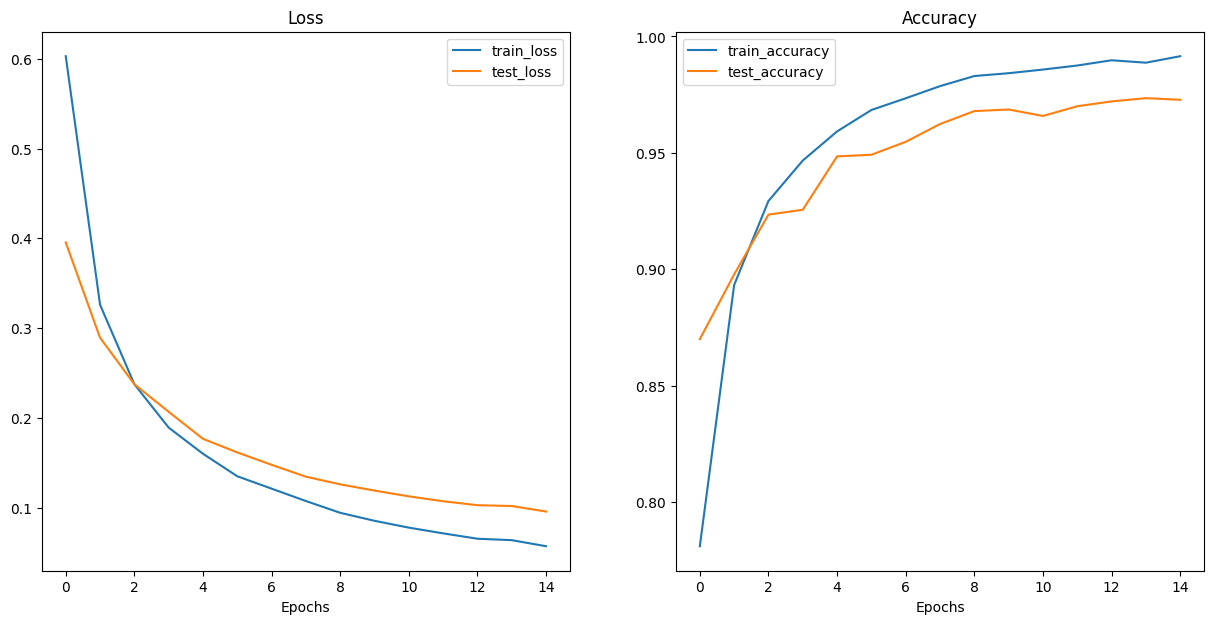

In [72]:
helper_functions.plot_loss_curves(pretrained_vit_results)

In [73]:
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt


# 1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str],
                       image_size: Tuple[int, int] = (224, 224),
                       transform: torchvision.transforms = None,
                       device: torch.device = device):
    
    # 2. Open the image with PIL
    img = Image.open(image_path)
    
    # 3. Create a transform if doesn't exist
    image_transform = vit_transforms
        
    # Predict on image---------------------------
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim = 0) #[B, C, H, W]
        
        # 7. Make a prediction on the transformed image by passing it to the model (also ensure it is on the target device)
        target_image_pred = model(transformed_image.to(device))
        
        # 8. Convert the model's output logits to pred probs
        target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
        
        # 9. Convert the model's pred probs to pred labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)
        
        # 10. Plot image with predicted label and probability
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | {target_image_pred_probs.max():.3f}")
        plt.axis(False);
    

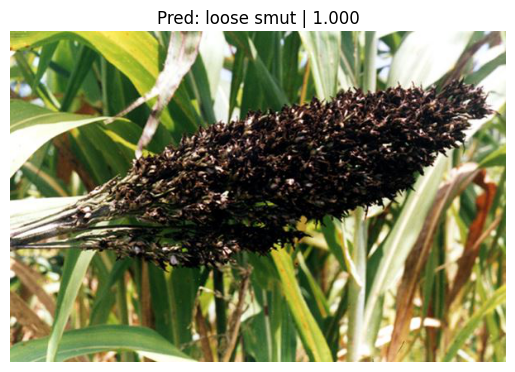

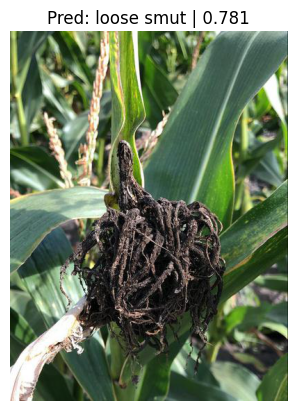

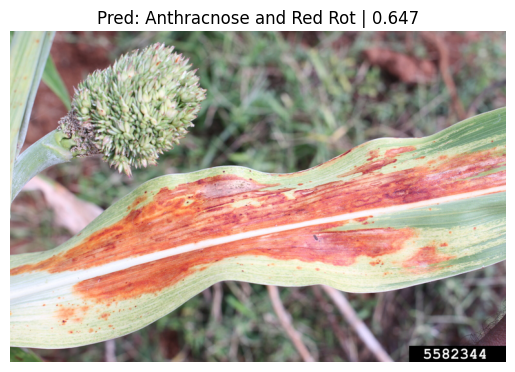

In [74]:
# Get a random list of image paths from the test set
import random
from pathlib import Path


num_images_to_plot = 3
test_image_path_list = list(Path("train_test_dataset/test/").glob("*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list,
                                      k = num_images_to_plot)
test_image_path_sample

# Predictions and plot
for image_path in test_image_path_sample:
    pred_and_plot_image(model = pretrained_vit,
                       image_path = image_path,
                       class_names = class_names,
                       image_size = (224, 224),
                       transform = vit_transforms,
                       device = device) 

### Saving the best performing ViT model

In [75]:
utils.save_full_model(model = pretrained_vit,
                           target_dir = "models",
                           model_name = "full_model_pretrained_vit_feature_extractor_sorghum.pth"
                           )

[INFO] Saving model to: models\full_model_pretrained_vit_feature_extractor_sorghum.pth


### Loading model and Predicting on a custom image

In [76]:
# Define the model path
model_path = "models/full_model_pretrained_vit_feature_extractor_sorghum.pth"

# Load the full model
loaded_model = torch.load(model_path, map_location=device)

# Set the model to evaluation mode
loaded_model.eval()

print("Full model loaded successfully!")


Full model loaded successfully!


# Confusion matrix and ROC curve

### effnet model 

In [24]:
import torch
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def evaluate_model(model_path, test_dir, image_size=(224, 224), batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the full model
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()

    # Data transforms
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    # Load test dataset
    test_data = datasets.ImageFolder(root=test_dir, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    class_names = test_data.classes
    num_classes = len(class_names)

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_probs.append(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels_np = np.array(all_labels)
    binary_labels = label_binarize(all_labels_np, classes=np.arange(num_classes))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig_cm, ax_cm = plt.subplots(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax_cm, xticks_rotation=45, colorbar=True)
    plt.title(f"Normalized Confusion Matrix: {os.path.basename(model_path)}")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {os.path.basename(model_path)}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


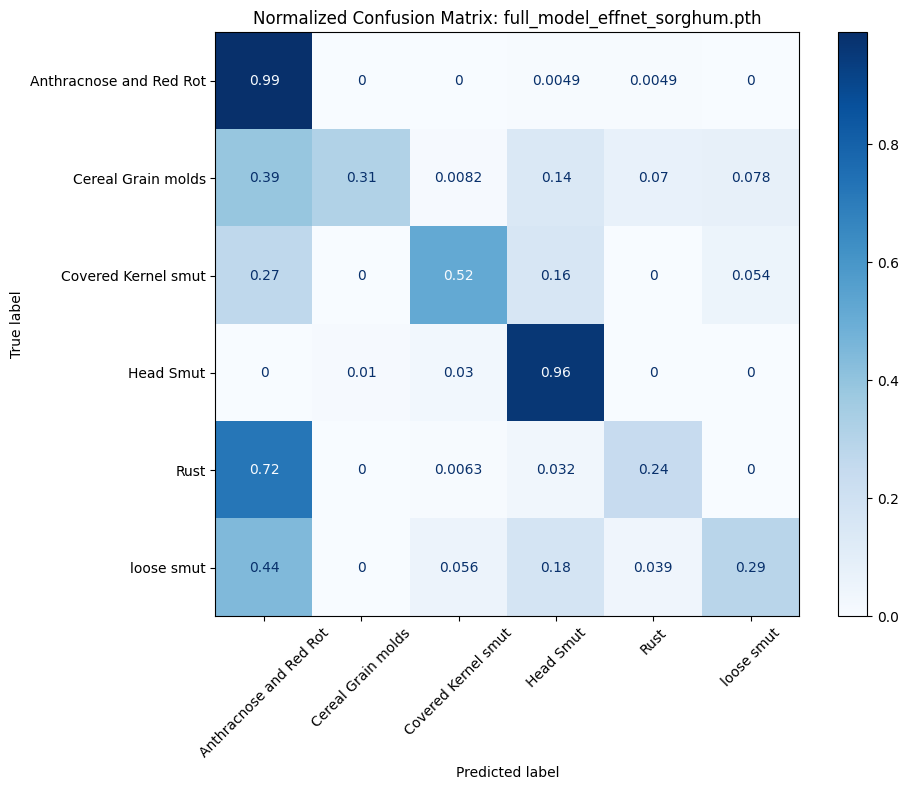

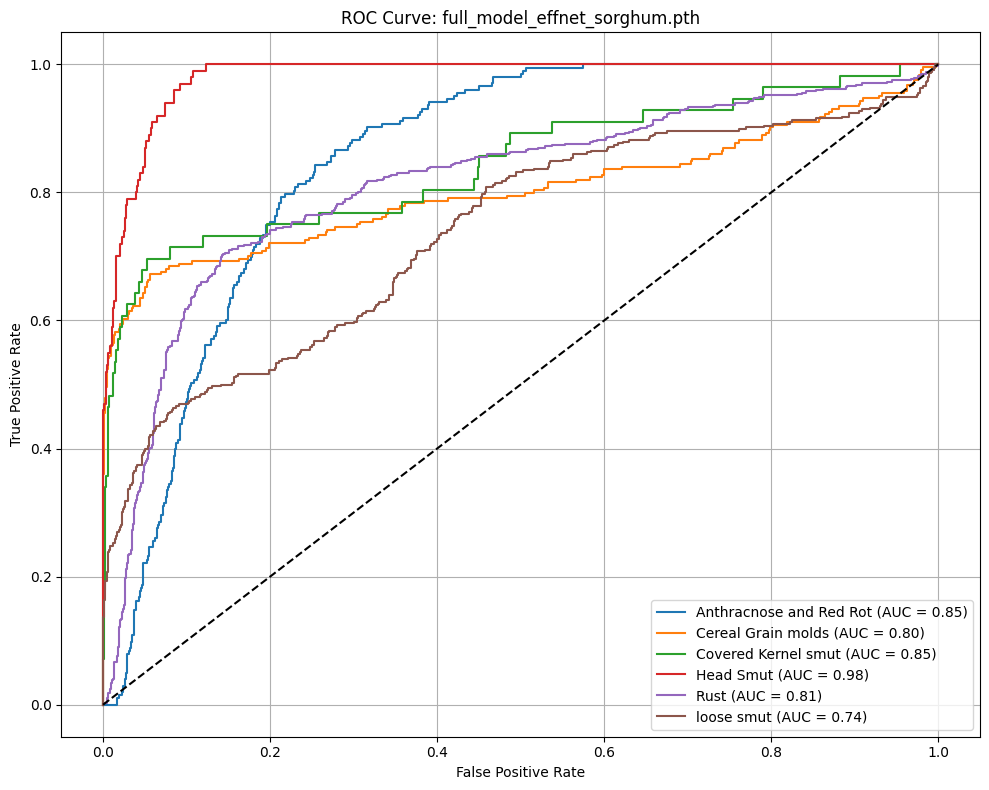

In [26]:
evaluate_model(
    model_path="models/full_model_effnet_sorghum.pth",
    test_dir="train_test_dataset/validation"
)

## Pretrained Vit Model

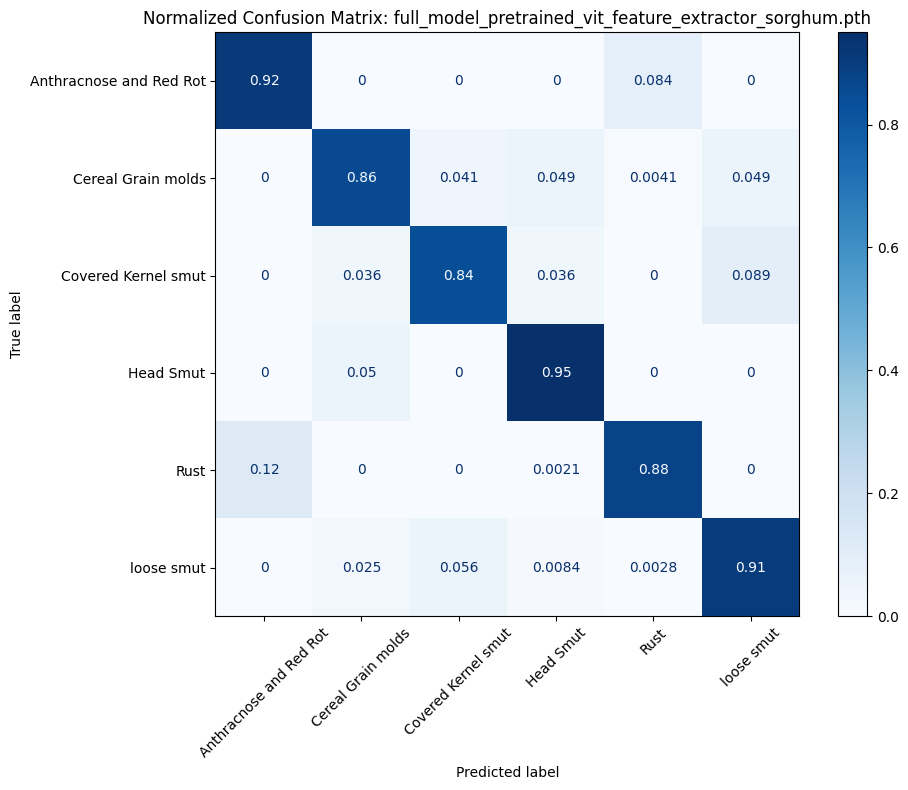

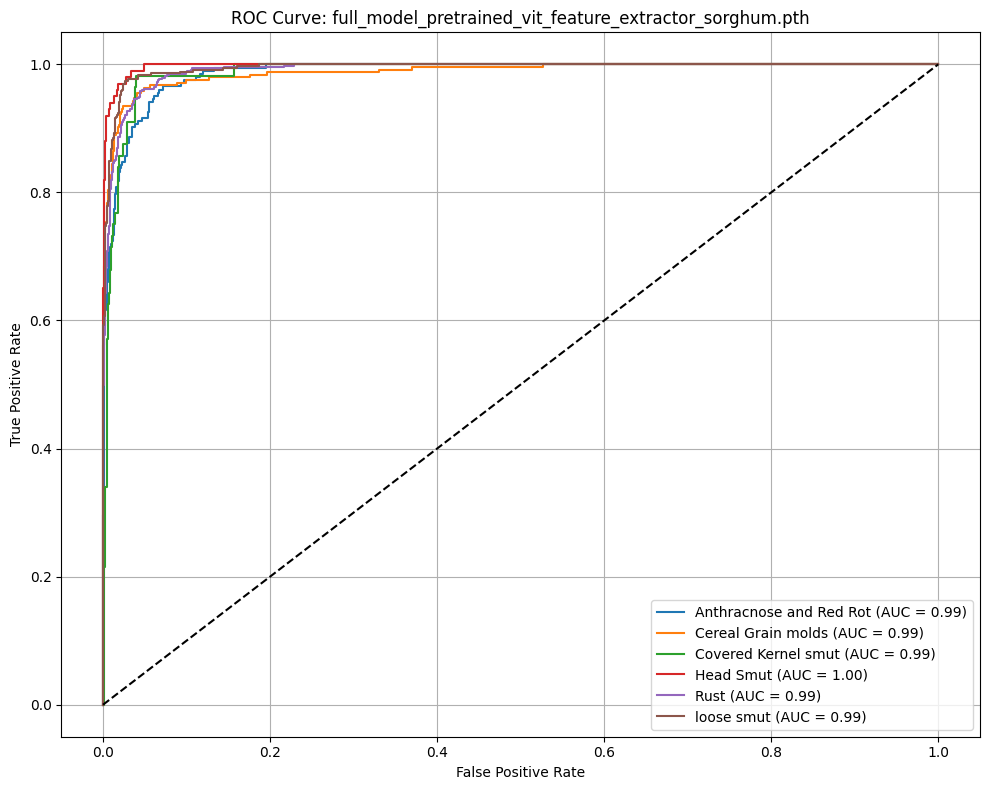

In [28]:
evaluate_model(
    model_path="models/full_model_pretrained_vit_feature_extractor_sorghum.pth",
    test_dir="train_test_dataset/validation"
)